#Analysis of CrowdFlower job #748223: Finding chemical-induced disease relationships for BioCreative V task 3b (version 3)

2015-06-30 Tong Shu Li<br>
Last updated 2015-06-30

Crowdflower job 748223 is the third version of the chemical-induced disease relationship extraction task for BioCreative V. This version is different from version 2 (#746297 and 746647) because the concept names were replaced with generic names. I wanted to see if this would reduce the complexity of the task that workers saw, and whether this would eliminate any ambiguity in the choices.

Job 748223 was launched at 5:09 pm on Monday, June 29, 2015 and completed at 1:20 am on Tuesday, June 30, 2015. The total cost was $57.00 USD.

Settings:
- 5 rows per page
- 5 judgements per row
- 50 cents per page
- level 1 contributor
- 50 seconds minimum per page
- worker has to maintain 70% minimum accuracy
- there were 11 test questions (test questions were the same as jobs 746297 and 746647)
- Responses to the test questions had to match exactly (all correct choices chosen, no incorrect choice chosen) in order to count as being correct

In [1]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from IPython.display import Image
import pandas as pd
import matplotlib as plt

In [2]:
%matplotlib inline

In [3]:
%%bash

rm src/get_AUC_value.pyc

rm: cannot remove ‘src/get_AUC_value.pyc’: No such file or directory


In [4]:
from src.filter_data import filter_data
from src.parse_gold import parse_input
from src.parse_gold import Relation
from src.get_AUC_value import get_AUC_value
from src.aggregate_votes import aggregate_votes

---

### Read the results of job 748223:

In [5]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_748223_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

Total number of judgements collected:

In [6]:
len(raw_data)

255

In [7]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,choice_2_label,choice_3_ids,choice_3_label,choice_4_ids,choice_4_label,form_abstract,form_title,pmid,reading_difficulty_gold,uniq_id
1,745851158,6/30/2015 00:23:33,False,1675788021,NaN,6/30/2015 00:18:42,False,elite,0.7273,29965133,...,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,NaN,bcv_id_0
3,745851158,6/30/2015 00:24:23,False,1675788510,NaN,6/30/2015 00:16:15,False,elite,0.7273,30542998,...,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,NaN,bcv_id_0
5,745851158,6/30/2015 00:54:24,False,1675804809,NaN,6/30/2015 00:51:01,False,elite,0.8182,30999839,...,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,NaN,bcv_id_0
6,745851158,6/30/2015 01:10:56,False,1675813310,NaN,6/30/2015 01:02:06,False,neodev,0.8182,32872588,...,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,NaN,bcv_id_0
8,745851158,6/30/2015 06:24:24,False,1675952794,NaN,6/30/2015 06:16:59,False,elite,0.7143,32626875,...,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,NaN,bcv_id_0


In [8]:
raw_data["comment_box"].unique()

array([nan,
       'As far as I understand, administering chemical A to patients with disease Q, in dose above 600mg/m2 frequently causes disease P. Therefore, A plays a role in P'], dtype=object)

### Cleaning the data:

Before we can aggregate the individual votes, we need to ensure that the responses make sense.

- "None are true" should be the only choice if selected.
- No empty choices should have been selected.

In [9]:
def check_data(data_frame):
    bad_responses = set()

    for idx, row in data_frame.iterrows():
        unit_id = row["_unit_id"]
        worker_id = row["_worker_id"]

        response = set(row["chemical_disease_relationships"].split('\n'))

        # if none are true, then it should be the only choice..
        if "none_are_true" in response and len(response) > 1:
            bad_responses.add((unit_id, worker_id))

        for i in range(5):
            column = "choice_{0}_ids".format(i)
            if (row[column] == "empty") and ("choice_{0}".format(i) in response): # clicked empty response
                bad_responses.add((unit_id, worker_id))
                
    return bad_responses

In [10]:
check_data(raw_data)

set()

Great, everyone followed the rules perfectly and did not make any errors with the choice selection.

## Aggregation scheme:

1. Aggregate on unique id (one subset of the N x M expansion of all drug-disease pairs). Normalize scores by the total trust score of all workers who worked on that work unit.
2. Aggregate above results on PMID
3. Return a ranked list of drug-disease pairs for each PMID
4. Perform ROC analysis on ranked list using normalized threshold.

Consider the case where we have M choices voted upon by N people. One of the M choices is that "None of the given choices are true". How do we aggregate votes?

Since the M choices represent the set of all possible drug-disease relationships in an abstract, we want a list of the possible relationships for any one work unit, with a score of how confident we are that that relationship might be true. Notice that picking the top answer is not the right approach because we would lose lots of information.

With these considerations in mind, the voting scheme will be as follows:
1. Choices which a person does not select are untouched.
2. Choices which a person explicitly picks gets their trust score added to that choice.
3. The "none of the above" choice applies the negative trust score to every other choice.

Finally, all the choices are sorted by decreasing score. Negative scores represent cases where more people said that choice was wrong than people who said it was right.

In [11]:
def generate_results(data_frame, penalize_unchosen = False):
    results = []
    for pmid, pmid_group in data_frame.groupby("pmid"):
        temp = []
        for uniq_id, group in pmid_group.groupby("uniq_id"):
            scores = aggregate_votes(uniq_id, group, penalize_unchosen)
            temp.append(scores)

        df = pd.concat(temp)
        if not df.empty:
            df = df.sort("normalized_score", axis = 0, ascending = False)
            df["pmid"] = pmid
            results.append(df)
            
    return pd.concat(results)

In [12]:
results = generate_results(raw_data)

In [13]:
results.head()

,id_pair,normalized_score,uniq_id,unit_id,pmid
0,D002512_induces_D007683,0.812288,bcv_id_46,745851204,1130930
1,D005839_induces_D009846|D051437,0.800735,bcv_id_45,745851203,1130930
2,D005839_induces_D007683,0.800735,bcv_id_45,745851203,1130930
0,D002512_induces_D009846|D051437,0.601471,bcv_id_45,745851203,1130930
3,D005839_induces_D007674,0.601471,bcv_id_45,745851203,1130930


Now that we have our results table, listing the drug-disease relationships with a confidence score, we can perform a ROC analysis on the score as a predictor. To generate our ROC curve, we will:

1. Use the gold standard to look up whether each disease pair id was a true positive or not.
2. Use the R ROCR package to generate the ROC curve.

In [14]:
training_data = parse_input("data/training", "CDR_TrainingSet.txt")

In [15]:
used_pmids = set(raw_data["pmid"].unique())
print len(used_pmids)
used_pmids

30


{1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 2515254,
 3800626,
 6666578,
 6692345,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10520387,
 10835440,
 11135224,
 11569530,
 12041669,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 17931375,
 18631865,
 19269743}

In [16]:
gold_relations = dict()
for paper in training_data:
    if int(paper.pmid) in used_pmids:
        gold_relations[paper.pmid] = paper.relations

In [17]:
def in_gold(pmid, annot):
    """
    Sometimes a drug-disease relationship will contain
    only one identifier for each concept, and the id
    won't show up by itself in the annotations, but as
    part of a complex annotation.
    
    For example, in PMID 1130930, there is a relation
    between D002512 and D009846, but D009846 is not the
    identifier for any annotation. The only annotation
    with D009846 is D009846|D051437, and therefore an
    exact match is not the right way to check for equality.
    """
    drug_ids = set(annot.drug.split('|'))
    disease_ids = set(annot.disease.split('|'))
    for gold_rel in gold_relations[str(pmid)]:
        if gold_rel.drug in drug_ids and gold_rel.disease in disease_ids:
            return True
        
    return False

In [18]:
def determine_truth(data_frame):
    """
    Determines if each choice is in the gold.
    """
    is_in_gold = []
    for idx, row in results.iterrows():
        pmid = row["pmid"]
        temp = row["id_pair"].split("_induces_")
        annot = Relation(temp[0], temp[1])

        is_in_gold.append(int(in_gold(pmid, annot)))
        
    return is_in_gold

In [19]:
results["in_gold"] = determine_truth(results)

In [20]:
results

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D002512_induces_D007683,0.812288,bcv_id_46,745851204,1130930,1
1,D005839_induces_D009846|D051437,0.800735,bcv_id_45,745851203,1130930,1
2,D005839_induces_D007683,0.800735,bcv_id_45,745851203,1130930,1
0,D002512_induces_D009846|D051437,0.601471,bcv_id_45,745851203,1130930,1
3,D005839_induces_D007674,0.601471,bcv_id_45,745851203,1130930,0
1,D002512_induces_D007674,0.593856,bcv_id_46,745851204,1130930,0
4,D005839_induces_D051437,0.000000,bcv_id_45,745851203,1130930,0
2,D002512_induces_D051437,0.000000,bcv_id_46,745851204,1130930,0
0,D008094_induces_D007676,1.000000,bcv_id_7,745851165,1378968,1
0,D008094_induces_D007674,0.590892,bcv_id_6,745851164,1378968,0


### Perform a ROC analysis on all 30 abstracts:

In [21]:
fname = "data/roc/job_748223_roc.png"
title = "ROC curve for all 30 abstracts of job 748223"
get_AUC_value(results, "normalized_score", "in_gold", fname, title)

0.8777777777777778

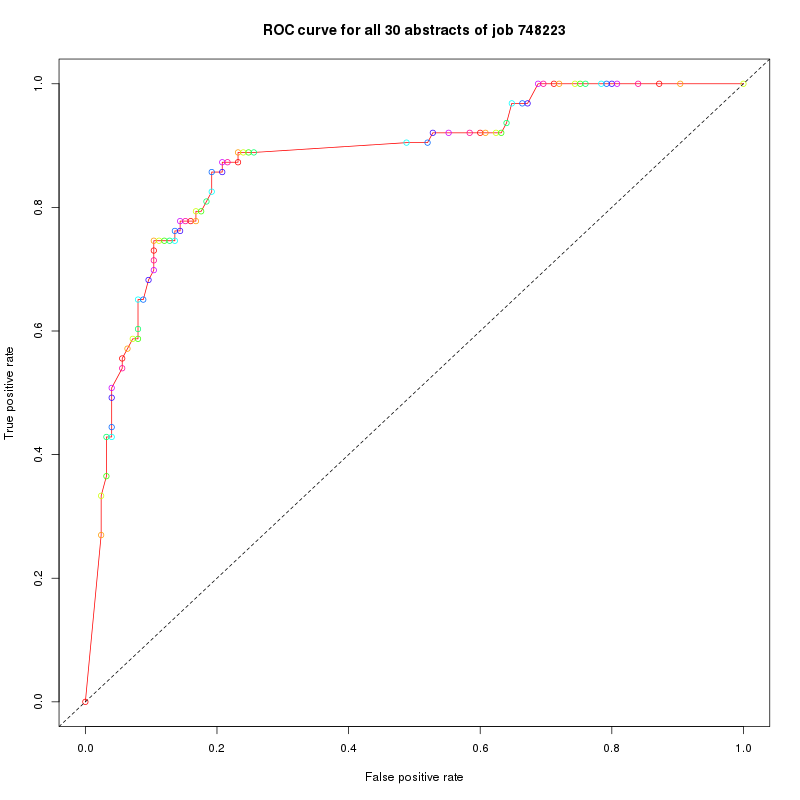

In [22]:
Image(filename = fname)

In [23]:
def F_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)
    
def max_F_score(data_frame):
    """
    Given the results dataframe for one or many PMIDs, with the in_gold
    column already determined, this function determines the max
    F score with respect to the gold standard and the value of
    the normalized voting score at which the max F score is achieved.
    """
    EPSILON = 0.0000001
    
    max_f_score = 0
    best_threshold = 9999
    best_res = (-1, -1)
    
    for threshold in data_frame["normalized_score"].unique():
        sub = data_frame.query("normalized_score > {0} or -{1} <= normalized_score - {0} <= {1}".format(threshold, EPSILON))
        
        recall = sum(sub["in_gold"]) / sum(data_frame["in_gold"])
        precision = sum(sub["in_gold"]) / len(sub)
        
        f_score = F_score(precision, recall)
        
        if f_score > max_f_score:
            max_f_score = f_score
            best_res = (precision, recall)
            best_threshold = threshold
            
    return (max_f_score, best_res[0], best_res[1], best_threshold)

In [24]:
max_F_score(results)

(0.76595744680851074,
 0.69230769230769229,
 0.8571428571428571,
 0.19198184568835103)

---

In [25]:
def question_difficulty(data_frame):
    """
    Looks at what the crowd thought about the difficulty of each abstract.
    """
    scores = {
        "very_easy": 1,
        "easy": 2,
        "intermediate": 3,
        "hard": 4,
        "very_hard": 5
    }
    
    res = defaultdict(float)
    for pmid, group in data_frame.groupby("pmid"):
        for val, num in Counter(group["reading_difficulty"]).most_common():
            res[pmid] += scores[val] * num
            
        res[pmid] /= len(group)
        
    return res

In [26]:
best_f = dict()
for pmid, group in results.groupby("pmid"):
    best_f[pmid] = max_F_score(group)
    
temp = [(key, val) for key, val in best_f.items()]
temp = sorted(temp, key = lambda x: -x[1][0])
temp

[(15602202, (1.0, 1.0, 1.0, 1.0)),
 (1835291, (1.0, 1.0, 1.0, 0.16383980557946429)),
 (15632880, (1.0, 1.0, 1.0, 0.6190451247937564)),
 (2265898, (1.0, 1.0, 1.0, 1.0)),
 (3800626, (1.0, 1.0, 1.0, 0.18604829632661413)),
 (2515254, (1.0, 1.0, 1.0, 1.0)),
 (18631865, (1.0, 1.0, 1.0, 1.0)),
 (10520387, (1.0, 1.0, 1.0, 0.4297871290792038)),
 (12041669, (1.0, 1.0, 1.0, 1.0)),
 (19269743, (1.0, 1.0, 1.0, 0.62457624891598551)),
 (6666578, (1.0, 1.0, 1.0, 1.0)),
 (9522143, (1.0, 1.0, 1.0, 0.19198184568835103)),
 (8595686, (1.0, 1.0, 1.0, 0.58139772843548554)),
 (16167916, (1.0, 1.0, 1.0, 1.0)),
 (17931375, (1.0, 1.0, 1.0, 1.0)),
 (10835440, (1.0, 1.0, 1.0, 1.0)),
 (2096243, (1.0, 1.0, 1.0, 0.80073549109860942)),
 (7449470, (1.0, 1.0, 1.0, 0.2240899194977469)),
 (17261653, (1.0, 1.0, 1.0, 0.55874936964195665)),
 (8590259,
  (0.90909090909090906, 0.83333333333333337, 1.0, 0.59523871880156087)),
 (1130930,
  (0.88888888888888895, 0.80000000000000004, 1.0, 0.60147098219721884)),
 (1378968, (0.85714

In [27]:
results.query("pmid == 17241784")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
3,D019821_induces_D009135,1,bcv_id_17,745851175,17241784,1
0,D011239_induces_D009135,0,bcv_id_17,745851175,17241784,0
1,D008727_induces_D009135,0,bcv_id_17,745851175,17241784,0
2,D008727_induces_D009336,0,bcv_id_17,745851175,17241784,0
4,D019821_induces_D009336,0,bcv_id_17,745851175,17241784,1
0,D011239_induces_D009336,-1,bcv_id_18,745851176,17241784,0


In [28]:
results.query("pmid == 6692345")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D001241_induces_D013274,0.581398,bcv_id_41,745851199,6692345,0
2,D005200_induces_D001749,0.384944,bcv_id_40,745851198,6692345,1
3,D005200_induces_D013274,0.211416,bcv_id_40,745851198,6692345,1
1,D005200_induces_D063646,0.179399,bcv_id_40,745851198,6692345,0
0,D001241_induces_D001749,0.003725,bcv_id_40,745851198,6692345,0
4,D001241_induces_D063646,-0.201820,bcv_id_40,745851198,6692345,0


In [29]:
difficulty = question_difficulty(raw_data)

In [30]:
difficulty

defaultdict(<type 'float'>, {1378968: 2.6666666666666665, 15602202: 2.4, 1835291: 2.4, 15632880: 2.85, 2265898: 2.1, 1130930: 1.8, 3800626: 1.6, 8590259: 2.5, 2515254: 2.2, 17241784: 2.1, 18631865: 2.2, 10520387: 2.7, 12041669: 1.2, 19269743: 1.8, 6666578: 2.4, 7582165: 1.8, 9522143: 2.8, 2375138: 1.8, 8595686: 2.1, 16167916: 2.1, 17931375: 1.6, 10835440: 2.8, 16337777: 2.4, 2096243: 2.2, 12198388: 2.65, 11135224: 2.7333333333333334, 6692345: 2.5, 11569530: 2.1, 7449470: 2.2, 17261653: 2.7})

In [31]:
lol = defaultdict(list)
for pmid, val in best_f.items():
    lol["pmid"].append(pmid)
    lol["difficulty"].append(difficulty[pmid])
    lol["best_f"].append(val[0])
    lol["threshold"].append(val[3])
    
    
rofl = pd.DataFrame(lol)

In [32]:
rofl

,best_f,difficulty,pmid,threshold
0,0.857143,2.666667,1378968,0.590892
1,1.000000,2.400000,15602202,1.000000
2,1.000000,2.400000,1835291,0.163840
3,1.000000,2.850000,15632880,0.619045
4,1.000000,2.100000,2265898,1.000000
5,0.888889,1.800000,1130930,0.601471
6,1.000000,1.600000,3800626,0.186048
7,0.909091,2.500000,8590259,0.595239
8,1.000000,2.200000,2515254,1.000000
9,0.666667,2.100000,17241784,1.000000


In [65]:
results.query("pmid == 1130930")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D002512_induces_D007683,0.812288,bcv_id_46,745851204,1130930,1
1,D005839_induces_D009846|D051437,0.800735,bcv_id_45,745851203,1130930,1
2,D005839_induces_D007683,0.800735,bcv_id_45,745851203,1130930,1
0,D002512_induces_D009846|D051437,0.601471,bcv_id_45,745851203,1130930,1
3,D005839_induces_D007674,0.601471,bcv_id_45,745851203,1130930,0
1,D002512_induces_D007674,0.593856,bcv_id_46,745851204,1130930,0
4,D005839_induces_D051437,0.000000,bcv_id_45,745851203,1130930,0
2,D002512_induces_D051437,0.000000,bcv_id_46,745851204,1130930,0


In [34]:
rofl.query("best_f < 1").sort("pmid")

,best_f,difficulty,pmid,threshold
5,0.888889,1.800000,1130930,0.601471
0,0.857143,2.666667,1378968,0.590892
17,0.800000,1.800000,2375138,1.000000
26,0.800000,2.500000,6692345,0.211416
15,0.800000,1.800000,7582165,0.595991
7,0.909091,2.500000,8590259,0.595239
25,0.631579,2.733333,11135224,-0.394852
27,0.857143,2.100000,11569530,0.617744
24,0.800000,2.650000,12198388,0.641203
22,0.666667,2.400000,16337777,0.602931


In [35]:
max_F_score(results.query("pmid == 12198388"))

(0.80000000000000004, 1.0, 0.66666666666666663, 0.6412027330356922)

In [36]:
results.query("pmid == 12198388")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D009388_induces_D012640,0.641203,bcv_id_30,745851188,12198388,1
1,D009538_induces_D012640,0.641203,bcv_id_30,745851188,12198388,1
2,D000431_induces_D012640,0.619045,bcv_id_29,745851187,12198388,0
3,D012964_induces_D012640,0.602931,bcv_id_28,745851186,12198388,0
1,D000109_induces_D012640,0.599267,bcv_id_28,745851186,12198388,0
0,D002217_induces_D012640,0.397069,bcv_id_28,745851186,12198388,1
3,C522374_induces_D012640,0.227967,bcv_id_30,745851188,12198388,0
2,D009538_induces_D014202,0.224242,bcv_id_30,745851188,12198388,0
4,D011188_induces_D012640,0.023806,bcv_id_29,745851187,12198388,0
2,D000109_induces_D014202,0.000000,bcv_id_28,745851186,12198388,0


In [37]:
set(rofl.query("best_f < 1")["pmid"])

{1130930,
 1378968,
 2375138,
 6692345,
 7582165,
 8590259,
 11135224,
 11569530,
 12198388,
 16337777,
 17241784}

In [38]:
set(rofl.query("best_f == 1.0")["pmid"])

{1835291,
 2096243,
 2265898,
 2515254,
 3800626,
 6666578,
 7449470,
 8595686,
 9522143,
 10520387,
 10835440,
 12041669,
 15602202,
 15632880,
 16167916,
 17261653,
 17931375,
 18631865,
 19269743}

In [39]:
def paper_length(pmid):
    for paper in training_data:
        if int(paper.pmid) == pmid:
            return len(paper.title) + len(paper.abstract)
            
paper_length(17261653)
rofl["length"] = rofl["pmid"].map(paper_length)

In [40]:
rofl

,best_f,difficulty,pmid,threshold,length
0,0.857143,2.666667,1378968,0.590892,1891
1,1.000000,2.400000,15602202,1.000000,470
2,1.000000,2.400000,1835291,0.163840,1177
3,1.000000,2.850000,15632880,0.619045,1892
4,1.000000,2.100000,2265898,1.000000,671
5,0.888889,1.800000,1130930,0.601471,526
6,1.000000,1.600000,3800626,0.186048,842
7,0.909091,2.500000,8590259,0.595239,1368
8,1.000000,2.200000,2515254,1.000000,866
9,0.666667,2.100000,17241784,1.000000,1066


In [41]:
results.query("pmid == 15632880")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D013148_induces_D051437,0.619045,bcv_id_25,745851183,15632880,1
3,D013148_induces_D006947,0.619045,bcv_id_25,745851183,15632880,1
1,D049971_induces_D051437,0.214284,bcv_id_25,745851183,15632880,0
4,D013148_induces_D003920,0.000000,bcv_id_25,745851183,15632880,0
2,D013148_induces_D006333,-0.190477,bcv_id_25,745851183,15632880,0
0,D011188_induces_D006947,-0.218372,bcv_id_23,745851181,15632880,0
3,D003404_induces_D051437,-0.218372,bcv_id_23,745851181,15632880,0
1,D003404_induces_D006947,-0.609186,bcv_id_23,745851181,15632880,0
2,D003404_induces_D003920,-0.609186,bcv_id_23,745851181,15632880,0
4,D011188_induces_D006333,-0.609186,bcv_id_23,745851181,15632880,0


In [42]:
b = set(rofl.query("best_f < 1")["pmid"])

In [43]:
#748223
b

{1130930,
 1378968,
 2375138,
 6692345,
 7582165,
 8590259,
 11135224,
 11569530,
 12198388,
 16337777,
 17241784}

In [44]:
a = {'11135224',
 '1130930',
 '11569530',
 '12198388',
 '1378968',
 '16337777',
 '2375138',
 '6692345',
 '7449470',
 '7582165'}

a = set(map(int, a))

In [45]:
# 746297
a

{1130930,
 1378968,
 2375138,
 6692345,
 7449470,
 7582165,
 11135224,
 11569530,
 12198388,
 16337777}

In [46]:
a & b

{1130930,
 1378968,
 2375138,
 6692345,
 7582165,
 11135224,
 11569530,
 12198388,
 16337777}

In [47]:
a - b

{7449470}

Managed to clear up the difficulty for pmid 7449470, but the confidence was low..

In [48]:
results.query("pmid == 7449470")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D004317_induces_D009202,0.224090,bcv_id_38,745851196,7449470,1
1,D004317_induces_D066126,0.013139,bcv_id_38,745851196,7449470,0


In [49]:
b - a

{8590259, 17241784}

the response to pmid 8590259 is ok because it wasn't clear how I wanted people to treat "statistically but not clinically significant". It's probably by chance that the previous job got it while this job didn't.

In [50]:
max_F_score(results.query("pmid == 17241784"))

(0.66666666666666663, 1.0, 0.5, 1.0)

In [51]:
results.query("pmid == 17241784")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
3,D019821_induces_D009135,1,bcv_id_17,745851175,17241784,1
0,D011239_induces_D009135,0,bcv_id_17,745851175,17241784,0
1,D008727_induces_D009135,0,bcv_id_17,745851175,17241784,0
2,D008727_induces_D009336,0,bcv_id_17,745851175,17241784,0
4,D019821_induces_D009336,0,bcv_id_17,745851175,17241784,1
0,D011239_induces_D009336,-1,bcv_id_18,745851176,17241784,0


There seem to be a pool of papers which the crowd isn't able to get quite right despite changing the question around..

In [52]:
max_F_score(results.query("pmid == 1130930"))

(0.88888888888888895, 0.80000000000000004, 1.0, 0.60147098219721884)

In [53]:
results.query("pmid == 1130930")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D002512_induces_D007683,0.812288,bcv_id_46,745851204,1130930,1
1,D005839_induces_D009846|D051437,0.800735,bcv_id_45,745851203,1130930,1
2,D005839_induces_D007683,0.800735,bcv_id_45,745851203,1130930,1
0,D002512_induces_D009846|D051437,0.601471,bcv_id_45,745851203,1130930,1
3,D005839_induces_D007674,0.601471,bcv_id_45,745851203,1130930,0
1,D002512_induces_D007674,0.593856,bcv_id_46,745851204,1130930,0
4,D005839_induces_D051437,0.000000,bcv_id_45,745851203,1130930,0
2,D002512_induces_D051437,0.000000,bcv_id_46,745851204,1130930,0


In [54]:
a - b

{7449470}

In [55]:
b - a

{8590259, 17241784}

In [56]:
rofl.query("pmid == 7449470")

,best_f,difficulty,pmid,threshold,length
28,1,2.2,7449470,0.22409,438


In [57]:
results.query("pmid == 7449470")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
0,D004317_induces_D009202,0.224090,bcv_id_38,745851196,7449470,1
1,D004317_induces_D066126,0.013139,bcv_id_38,745851196,7449470,0


In [58]:
raw_data.query("pmid == 7449470")

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,choice_2_label,choice_3_ids,choice_3_label,choice_4_ids,choice_4_label,form_abstract,form_title,pmid,reading_difficulty_gold,uniq_id
283,745851196,6/30/2015 01:23:03,False,1675820187,NaN,6/30/2015 01:21:38,False,elite,0.8182,30936260,...,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"<span class=""disease"">[disease Q]</span> is a ...","Late, late <span class=""chemical"">[chemical A]...",7449470,NaN,bcv_id_38
285,745851196,6/30/2015 01:35:19,False,1675826765,NaN,6/30/2015 01:29:23,False,clixsense,0.7273,18526351,...,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"<span class=""disease"">[disease Q]</span> is a ...","Late, late <span class=""chemical"">[chemical A]...",7449470,NaN,bcv_id_38
286,745851196,6/30/2015 02:24:05,False,1675852318,NaN,6/30/2015 02:21:15,False,neodev,0.8571,27555842,...,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"<span class=""disease"">[disease Q]</span> is a ...","Late, late <span class=""chemical"">[chemical A]...",7449470,NaN,bcv_id_38
287,745851196,6/30/2015 04:07:41,False,1675898159,NaN,6/30/2015 03:57:24,False,elite,0.8333,32708888,...,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"<span class=""disease"">[disease Q]</span> is a ...","Late, late <span class=""chemical"">[chemical A]...",7449470,NaN,bcv_id_38
288,745851196,6/30/2015 06:05:10,False,1675944965,NaN,6/30/2015 05:59:03,False,elite,0.7143,32626875,...,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"<span class=""disease"">[disease Q]</span> is a ...","Late, late <span class=""chemical"">[chemical A]...",7449470,NaN,bcv_id_38


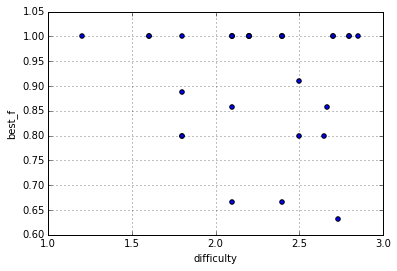

In [59]:
rofl.plot(kind = "scatter", x = "difficulty", y = "best_f")

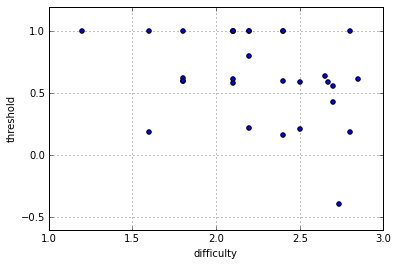

In [60]:
rofl.plot(kind = "scatter", x = "difficulty", y = "threshold")

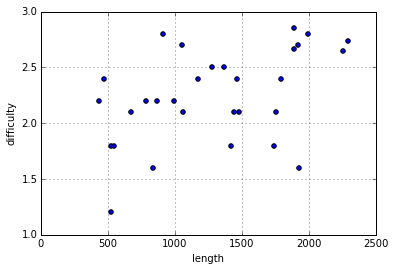

In [61]:
rofl.plot(kind = "scatter", x = "length", y = "difficulty")

In [62]:
rofl.query("length < 1000 and difficulty > 2.5")

,best_f,difficulty,pmid,threshold,length
16,1,2.8,9522143,0.191982,914


In [63]:
results.query("pmid == 9522143")

,id_pair,normalized_score,uniq_id,unit_id,pmid,in_gold
1,D011318_induces_D034381,0.191982,bcv_id_16,745851174,9522143,1
3,D002045_induces_D034381,0.191982,bcv_id_16,745851174,9522143,1
0,D011318_induces_D006319,-0.404009,bcv_id_16,745851174,9522143,0
2,D002045_induces_D006319,-0.404009,bcv_id_16,745851174,9522143,0


In [64]:
rofl

,best_f,difficulty,pmid,threshold,length
0,0.857143,2.666667,1378968,0.590892,1891
1,1.000000,2.400000,15602202,1.000000,470
2,1.000000,2.400000,1835291,0.163840,1177
3,1.000000,2.850000,15632880,0.619045,1892
4,1.000000,2.100000,2265898,1.000000,671
5,0.888889,1.800000,1130930,0.601471,526
6,1.000000,1.600000,3800626,0.186048,842
7,0.909091,2.500000,8590259,0.595239,1368
8,1.000000,2.200000,2515254,1.000000,866
9,0.666667,2.100000,17241784,1.000000,1066


It doesn't seem like crowd performance with respect to the gold is correlated with how easy they think the reading is.